# IMPORT

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os

import warnings 

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

from pathlib import Path

root_to_data = Path('/kaggle/input/rhinosurgical-patients/')

plt.style.use('ggplot')
warnings.simplefilter('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
!nvidia-smi

Tue Jul 16 10:23:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!export CUDA_LAUNCH_BLOCKING=1

In [6]:
table = pd.read_excel(f'{root_to_data}/datan.xlsx', nrows=73)
table
# table = table.iloc[:, :-11]


,age,gender,LF/HF,%VLF,%LF,%HF,LF/HF.1,%VLF.1,%LF.1,%HF.1,drop,y
0,6,ж,0.50,32.40,22.6,45.0,0.970000,23.6,36.30,40.1,False,0
1,6,ж,3.80,34.20,52.0,13.8,1.500000,32.9,39.70,27.4,False,0
2,3,ж,0.56,21.30,28.3,50.4,2.460000,49.5,35.90,14.6,False,0
3,6,ж,0.92,21.60,37.6,40.8,0.370000,28.9,19.10,52.0,False,0
4,4,ж,0.37,30.60,18.8,50.6,2.050000,46.1,36.20,17.7,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
68,8,м,2.20,23.50,52.8,23.7,0.560000,29.7,25.30,45.0,True,1
69,9,м,0.40,35.00,18.6,46.5,0.350000,13.7,22.50,63.9,True,1
70,7,м,0.20,5.48,15.5,79.0,0.100000,20.6,8.55,70.8,True,1
71,9,м,0.52,54.50,15.6,29.9,1.210000,52.7,25.90,21.4,True,1


In [7]:
table = table.fillna("-1")
table = table.drop(['drop'], axis=1)
table

,age,gender,LF/HF,%VLF,%LF,%HF,LF/HF.1,%VLF.1,%LF.1,%HF.1,y
0,6,ж,0.50,32.40,22.6,45.0,0.970000,23.6,36.30,40.1,0
1,6,ж,3.80,34.20,52.0,13.8,1.500000,32.9,39.70,27.4,0
2,3,ж,0.56,21.30,28.3,50.4,2.460000,49.5,35.90,14.6,0
3,6,ж,0.92,21.60,37.6,40.8,0.370000,28.9,19.10,52.0,0
4,4,ж,0.37,30.60,18.8,50.6,2.050000,46.1,36.20,17.7,0
...,...,...,...,...,...,...,...,...,...,...,...
68,8,м,2.20,23.50,52.8,23.7,0.560000,29.7,25.30,45.0,1
69,9,м,0.40,35.00,18.6,46.5,0.350000,13.7,22.50,63.9,1
70,7,м,0.20,5.48,15.5,79.0,0.100000,20.6,8.55,70.8,1
71,9,м,0.52,54.50,15.6,29.9,1.210000,52.7,25.90,21.4,1


In [9]:
label_encoder = LabelEncoder()

table['gender'] = label_encoder.fit_transform(table['gender'].values)
table['y'] = label_encoder.fit_transform(table['y'].values)

In [10]:
X = table.iloc[:, :-1]
y = table.iloc[:, -1]

print(X, y)

    age  gender  LF/HF   %VLF   %LF   %HF   LF/HF.1  %VLF.1  %LF.1  %HF.1
0     6       0   0.50  32.40  22.6  45.0  0.970000    23.6  36.30   40.1
1     6       0   3.80  34.20  52.0  13.8  1.500000    32.9  39.70   27.4
2     3       0   0.56  21.30  28.3  50.4  2.460000    49.5  35.90   14.6
3     6       0   0.92  21.60  37.6  40.8  0.370000    28.9  19.10   52.0
4     4       0   0.37  30.60  18.8  50.6  2.050000    46.1  36.20   17.7
..  ...     ...    ...    ...   ...   ...       ...     ...    ...    ...
68    8       1   2.20  23.50  52.8  23.7  0.560000    29.7  25.30   45.0
69    9       1   0.40  35.00  18.6  46.5  0.350000    13.7  22.50   63.9
70    7       1   0.20   5.48  15.5  79.0  0.100000    20.6   8.55   70.8
71    9       1   0.52  54.50  15.6  29.9  1.210000    52.7  25.90   21.4
72   42       0   0.94  12.30  38.9  48.8  1.111111    65.8  18.00   16.2

[73 rows x 10 columns] 0     0
1     0
2     0
3     0
4     0
     ..
68    1
69    1
70    1
71    1
72    0


In [11]:
# Масштабирование данных
scaler = StandardScaler()
X = scaler.fit_transform(X)
X[:10]

array([[-0.09311142, -1.42886902, -0.64569028,  0.16774466, -0.6710119 ,
         0.2761954 , -0.21447535, -0.75124798,  0.81592617,  0.2938324 ],
       [-0.09311142, -1.42886902,  2.93586138,  0.2759086 ,  1.94359546,
        -1.53744922,  0.34882576, -0.21203831,  1.16254641, -0.45962361],
       [-0.73034273, -1.42886902, -0.58057116, -0.49926632, -0.16409823,
         0.59009542,  1.36914476,  0.75042197,  0.77514732, -1.21901234],
       [-0.09311142, -1.42886902, -0.18985643, -0.48123899,  0.66297145,
         0.03205093, -0.85217472, -0.44395645, -0.93756446,  0.99982661],
       [-0.51793229, -1.42886902, -0.78678171,  0.05958072, -1.00895434,
         0.60172135,  0.93338352,  0.55329155,  0.80573146, -1.03509788],
       [-0.51793229, -1.42886902, -0.24412237,  0.18577198,  0.10269844,
        -0.24697132, -0.35264355,  0.89537081, -0.65211249, -0.53674902],
       [-0.51793229, -1.42886902, -0.50459885, -0.84178547,  0.22720356,
         0.66566395, -0.32075858, -1.48758807

## *KMeans*

In [12]:
kmeans = KMeans(n_clusters=2, random_state=42, init='k-means++', n_init='auto')
kmeans.fit(X)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

print(cluster_labels, '\n', cluster_centers)

[1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0
 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0] 
 [[ 0.15053584  0.26158767  0.58040062  0.60976756  0.37524955 -0.83416612
   0.32166449  0.41499331  0.00634602 -0.42882579]
 [-0.13123637 -0.22805078 -0.50599029 -0.53159224 -0.32714063  0.72722174
  -0.28042546 -0.36178904 -0.00553243  0.37384812]]


In [13]:
tsne = TSNE(n_components=2, n_jobs=-1)
X_tsne = tsne.fit_transform(X)
X_tsne

array([[-2.184029  ,  2.3560908 ],
       [ 1.2661053 ,  8.217635  ],
       [ 0.75970006,  1.7417047 ],
       [-3.4719608 ,  2.9813404 ],
       [ 0.60703   ,  1.5938303 ],
       [-0.41556248,  2.3129811 ],
       [-2.4879599 ,  3.0657718 ],
       [ 2.7512379 ,  2.4437716 ],
       [ 1.4452649 ,  6.1014047 ],
       [-0.9254702 ,  1.9921552 ],
       [-1.233006  ,  2.1912632 ],
       [-3.7999578 ,  3.1211915 ],
       [ 1.2950066 ,  1.4254923 ],
       [ 1.0227329 ,  1.5407151 ],
       [-2.9053695 ,  2.1783574 ],
       [-2.4685564 ,  2.1360161 ],
       [-1.505093  ,  1.9838866 ],
       [-2.5942483 ,  2.688945  ],
       [ 0.48291913,  2.091076  ],
       [ 1.5879595 ,  7.7677298 ],
       [-2.4275403 ,  2.538479  ],
       [-2.7438684 ,  2.2889044 ],
       [ 0.07736256,  0.97358483],
       [ 1.0638235 ,  3.9800384 ],
       [-0.64688045,  3.8454857 ],
       [-0.29329616,  7.0213704 ],
       [-2.5081265 ,  7.0452914 ],
       [-0.7673334 ,  4.6689153 ],
       [-2.6517498 ,

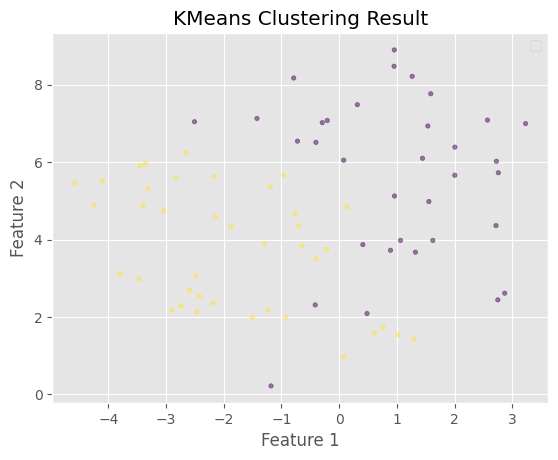

In [14]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', s=10,
            alpha=0.5)  # Точки данных в разных цветах в зависимости от кластера
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering Result')
plt.legend()
plt.show()

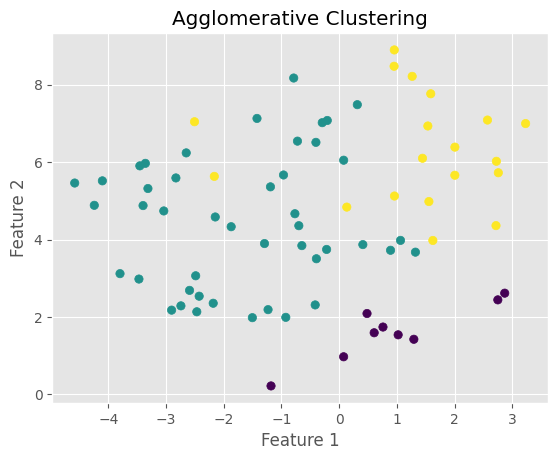

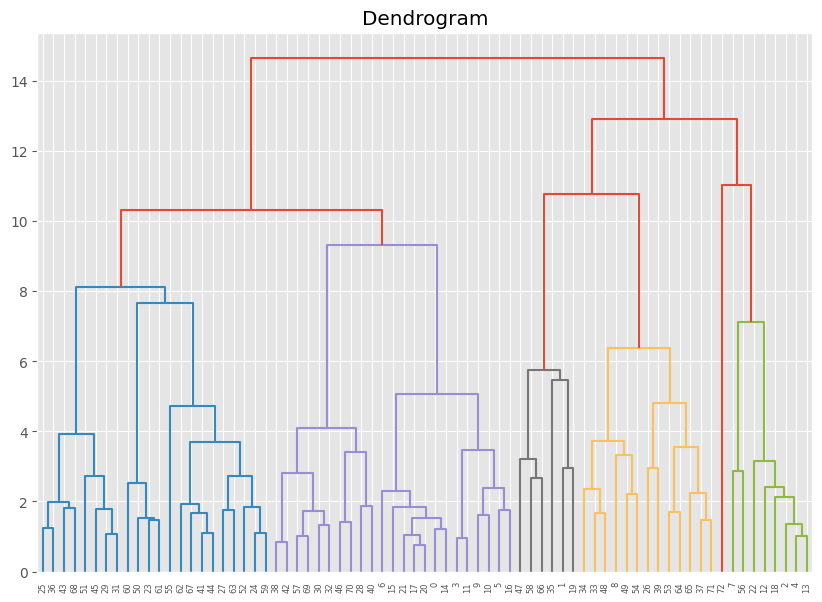

In [15]:
agg_clustering = AgglomerativeClustering(n_clusters=3)
labels = agg_clustering.fit_predict(X)

# Визуализация кластеров на 2D проекции (используя только первые два признака)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Построение дендрограммы для лучшего понимания структуры данных
linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram')
plt.show()

## Model 0 (unsupervied)

In [ ]:
from torch.nn import functional as F

class UnsupervisedAutoencoder(nn.Module):
    def __init__(self, D, K):
        super(UnsupervisedAutoencoder, self).__init__()
        self.centers = nn.Parameter(torch.randn(K, D))
        self.encoder = nn.Sequential(
            nn.Linear(D, D // 2),
            nn.ReLU(),
            nn.Linear(D // 2, D // 4),
            nn.ReLU(),
            nn.Linear(D // 4, D)
        )
        self.decoder = nn.Sequential(
            nn.Linear(D, D // 2),
            nn.ReLU(),
            nn.Linear(D // 2, D // 4),
            nn.ReLU(),
            nn.Linear(D // 4, D)
        )

    def forward(self, x):
        centers = self.centers.view(K, D)
        distances = ((centers - x)**2).sum(dim=1)
        return distances.argmin(dim=0)

    def predict(self, x):
        return self.forward(x).argmin(dim=1)

    def loss(self, x):
        predictions = self.predict(x)
        return F.cross_entropy(self.centers, predictions)


In [ ]:
N, D, K = X.shape[0], 2, 2

X_tensor = torch.tensor(X, dtype=torch.float32)

model = UnsupervisedAutoencoder(D, K)
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = model.loss

num_epoch = 10

# Обучение модели
for epoch in tqdm(range(10)):  # Количество эпох
    optimizer.zero_grad()
    loss = criterion(X_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        
# Предсказание кластеров для данных X
labels = model.predict(X_tensor)

# Визуализация результатов
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()


## Model 1

In [12]:
%time 

X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


model = SimpleNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

def train_model(model, criterion, optimizer, X_train, y_train, epochs=22, batch_size=10, validation_split=0.2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0

        X_train_batch, X_val_batch, y_train_batch, y_val_batch = train_test_split(X_train, y_train,
                                                                                  test_size=validation_split,
                                                                                  random_state=42)
        for i in range(0, len(X_train_batch), batch_size):
            inputs = torch.tensor(X_train_batch[i:i + batch_size])
            labels = torch.tensor(y_train_batch[i:i + batch_size])

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss}')


train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy}')
    auc = roc_auc_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted)
    print(f'Test F1: {f1}')
    print(f'Test roc auc:{auc}')


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [16]:
print(X[0])

[-0.09311142 -1.42886902 -0.64569028  0.16774466 -0.6710119   0.2761954
 -0.21447535 -0.75124798  0.81592617  0.2938324 ]


## Model 2

100%|██████████| 20/20 [00:00<00:00, 252.52it/s]


Fold 1/7, Epoch 1/20, Loss: 0.02280111082138554
Fold 1/7, Epoch 2/20, Loss: 0.023172736167907715
Fold 1/7, Epoch 3/20, Loss: 0.023390260434919787
Fold 1/7, Epoch 4/20, Loss: 0.02280401991259667
Fold 1/7, Epoch 5/20, Loss: 0.022277904133642872
Fold 1/7, Epoch 6/20, Loss: 0.022060423128066525
Fold 1/7, Epoch 7/20, Loss: 0.02212136310915793
Fold 1/7, Epoch 8/20, Loss: 0.021567777279884584
Fold 1/7, Epoch 9/20, Loss: 0.021576477635291316
Fold 1/7, Epoch 10/20, Loss: 0.021070178477994857
Fold 1/7, Epoch 11/20, Loss: 0.02094550863389046
Fold 1/7, Epoch 12/20, Loss: 0.02048584818840027
Fold 1/7, Epoch 13/20, Loss: 0.020025207150367
Fold 1/7, Epoch 14/20, Loss: 0.020401826789302212
Fold 1/7, Epoch 15/20, Loss: 0.02067450169594057
Fold 1/7, Epoch 16/20, Loss: 0.021251775564685944
Fold 1/7, Epoch 17/20, Loss: 0.020063258947864655
Fold 1/7, Epoch 18/20, Loss: 0.019823728069182363
Fold 1/7, Epoch 19/20, Loss: 0.018965982621715914
Fold 1/7, Epoch 20/20, Loss: 0.018781503362040364
Fold 1/7 Test Accu

100%|██████████| 20/20 [00:00<00:00, 255.83it/s]


Fold 2/7, Epoch 1/20, Loss: 0.019896798556850802
Fold 2/7, Epoch 2/20, Loss: 0.01976045197056186
Fold 2/7, Epoch 3/20, Loss: 0.019363427354443456
Fold 2/7, Epoch 4/20, Loss: 0.018868543447986726
Fold 2/7, Epoch 5/20, Loss: 0.018096100899481004
Fold 2/7, Epoch 6/20, Loss: 0.01862949902011502
Fold 2/7, Epoch 7/20, Loss: 0.018478575252717542
Fold 2/7, Epoch 8/20, Loss: 0.017280501704062184
Fold 2/7, Epoch 9/20, Loss: 0.01844225295128361
Fold 2/7, Epoch 10/20, Loss: 0.01840125072386957
Fold 2/7, Epoch 11/20, Loss: 0.017640814665825136
Fold 2/7, Epoch 12/20, Loss: 0.01812549848710337
Fold 2/7, Epoch 13/20, Loss: 0.01824107958424476
Fold 2/7, Epoch 14/20, Loss: 0.01792190920922064
Fold 2/7, Epoch 15/20, Loss: 0.01649431355537907
Fold 2/7, Epoch 16/20, Loss: 0.016668235102007465
Fold 2/7, Epoch 17/20, Loss: 0.016437689142842448
Fold 2/7, Epoch 18/20, Loss: 0.017014681331572995
Fold 2/7, Epoch 19/20, Loss: 0.016742118423984896
Fold 2/7, Epoch 20/20, Loss: 0.015801060584283644
Fold 2/7 Test Acc

  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3/7, Epoch 1/20, Loss: 0.01835194037806603
Fold 3/7, Epoch 2/20, Loss: 0.016925376749807788
Fold 3/7, Epoch 3/20, Loss: 0.017383136576221835
Fold 3/7, Epoch 4/20, Loss: 0.01682240924527568
Fold 3/7, Epoch 5/20, Loss: 0.01726877833566358
Fold 3/7, Epoch 6/20, Loss: 0.016631719566160632
Fold 3/7, Epoch 7/20, Loss: 0.016337954228924166


100%|██████████| 20/20 [00:00<00:00, 276.76it/s]


Fold 3/7, Epoch 8/20, Loss: 0.016778819984005343
Fold 3/7, Epoch 9/20, Loss: 0.015242975565694993
Fold 3/7, Epoch 10/20, Loss: 0.016390182318225983
Fold 3/7, Epoch 11/20, Loss: 0.016261172390753222
Fold 3/7, Epoch 12/20, Loss: 0.015659584153083064
Fold 3/7, Epoch 13/20, Loss: 0.014594253032438217
Fold 3/7, Epoch 14/20, Loss: 0.015097635407601633
Fold 3/7, Epoch 15/20, Loss: 0.016128268934065295
Fold 3/7, Epoch 16/20, Loss: 0.01494306662390309
Fold 3/7, Epoch 17/20, Loss: 0.0156709696016004
Fold 3/7, Epoch 18/20, Loss: 0.014470467644353066
Fold 3/7, Epoch 19/20, Loss: 0.014742500839694854
Fold 3/7, Epoch 20/20, Loss: 0.015023919843858289
Fold 3/7 Test Accuracy: 0.9090909090909091
Fold 3/7 Test F1: 0.8
Fold 3/7 Test roc auc: 0.8333333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4/7, Epoch 1/20, Loss: 0.013760359514327277
Fold 4/7, Epoch 2/20, Loss: 0.014581932908012754
Fold 4/7, Epoch 3/20, Loss: 0.013423184080729409
Fold 4/7, Epoch 4/20, Loss: 0.014216464190256028
Fold 4/7, Epoch 5/20, Loss: 0.014805862827906533
Fold 4/7, Epoch 6/20, Loss: 0.013005436885924567
Fold 4/7, Epoch 7/20, Loss: 0.013203461491872393
Fold 4/7, Epoch 8/20, Loss: 0.01290069402210296
Fold 4/7, Epoch 9/20, Loss: 0.013118460064842588


100%|██████████| 20/20 [00:00<00:00, 256.01it/s]


Fold 4/7, Epoch 10/20, Loss: 0.012401145602029467
Fold 4/7, Epoch 11/20, Loss: 0.013289875927425567
Fold 4/7, Epoch 12/20, Loss: 0.01260255631946382
Fold 4/7, Epoch 13/20, Loss: 0.012937266675252763
Fold 4/7, Epoch 14/20, Loss: 0.012678928791530548
Fold 4/7, Epoch 15/20, Loss: 0.012383384363991874
Fold 4/7, Epoch 16/20, Loss: 0.012545140016646613
Fold 4/7, Epoch 17/20, Loss: 0.011776477571517702
Fold 4/7, Epoch 18/20, Loss: 0.011000043342983911
Fold 4/7, Epoch 19/20, Loss: 0.01214876723667932
Fold 4/7, Epoch 20/20, Loss: 0.012238800998718019
Fold 4/7 Test Accuracy: 0.9
Fold 4/7 Test F1: 0.8
Fold 4/7 Test roc auc: 0.9375


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 5/7, Epoch 1/20, Loss: 0.012350572007043021
Fold 5/7, Epoch 2/20, Loss: 0.011912890369929964
Fold 5/7, Epoch 3/20, Loss: 0.012007769138093979
Fold 5/7, Epoch 4/20, Loss: 0.010818629037766229
Fold 5/7, Epoch 5/20, Loss: 0.011430632500421433
Fold 5/7, Epoch 6/20, Loss: 0.010799998801852029
Fold 5/7, Epoch 7/20, Loss: 0.01093688654521155
Fold 5/7, Epoch 8/20, Loss: 0.011572914464133126
Fold 5/7, Epoch 9/20, Loss: 0.01086456955425323
Fold 5/7, Epoch 10/20, Loss: 0.00993866106820485
Fold 5/7, Epoch 11/20, Loss: 0.009067331041608537
Fold 5/7, Epoch 12/20, Loss: 0.010178245249248687
Fold 5/7, Epoch 13/20, Loss: 0.010146239447215247
Fold 5/7, Epoch 14/20, Loss: 0.009823691750329638
Fold 5/7, Epoch 15/20, Loss: 0.009278572267956205
Fold 5/7, Epoch 16/20, Loss: 0.009674731228086684


100%|██████████| 20/20 [00:00<00:00, 269.72it/s]


Fold 5/7, Epoch 17/20, Loss: 0.010190439839211722
Fold 5/7, Epoch 18/20, Loss: 0.009871953536593725
Fold 5/7, Epoch 19/20, Loss: 0.009946349594328139
Fold 5/7, Epoch 20/20, Loss: 0.00961970431464059
Fold 5/7 Test Accuracy: 1.0
Fold 5/7 Test F1: 1.0
Fold 5/7 Test roc auc: 1.0


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 6/7, Epoch 1/20, Loss: 0.008523784459583343
Fold 6/7, Epoch 2/20, Loss: 0.009458210733201768
Fold 6/7, Epoch 3/20, Loss: 0.008628343778943259
Fold 6/7, Epoch 4/20, Loss: 0.008356166264367483
Fold 6/7, Epoch 5/20, Loss: 0.00780135676974342
Fold 6/7, Epoch 6/20, Loss: 0.00873531661336384
Fold 6/7, Epoch 7/20, Loss: 0.008603221840328641
Fold 6/7, Epoch 8/20, Loss: 0.0077924297915564645
Fold 6/7, Epoch 9/20, Loss: 0.008845937630486867
Fold 6/7, Epoch 10/20, Loss: 0.007610982845699977
Fold 6/7, Epoch 11/20, Loss: 0.007472244283509633
Fold 6/7, Epoch 12/20, Loss: 0.007245757513576084
Fold 6/7, Epoch 13/20, Loss: 0.006927866311300369
Fold 6/7, Epoch 14/20, Loss: 0.007094427706703307
Fold 6/7, Epoch 15/20, Loss: 0.007024113147977799
Fold 6/7, Epoch 16/20, Loss: 0.006645687042720734
Fold 6/7, Epoch 17/20, Loss: 0.006090296875862848
Fold 6/7, Epoch 18/20, Loss: 0.0072369374453075345


100%|██████████| 20/20 [00:00<00:00, 268.49it/s]


Fold 6/7, Epoch 19/20, Loss: 0.006978795168891785
Fold 6/7, Epoch 20/20, Loss: 0.006510016937104482
Fold 6/7 Test Accuracy: 0.9
Fold 6/7 Test F1: 0.8571428571428571
Fold 6/7 Test roc auc: 0.875


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 7/7, Epoch 1/20, Loss: 0.006797613605620369
Fold 7/7, Epoch 2/20, Loss: 0.007066925603245932
Fold 7/7, Epoch 3/20, Loss: 0.0070321451103876505
Fold 7/7, Epoch 4/20, Loss: 0.0063902319423736085
Fold 7/7, Epoch 5/20, Loss: 0.0068297166199911205
Fold 7/7, Epoch 6/20, Loss: 0.0068887219069496035
Fold 7/7, Epoch 7/20, Loss: 0.00596624305323949
Fold 7/7, Epoch 8/20, Loss: 0.00589942577339354
Fold 7/7, Epoch 9/20, Loss: 0.0063942789085327635
Fold 7/7, Epoch 10/20, Loss: 0.005800407320734054
Fold 7/7, Epoch 11/20, Loss: 0.00607077990259443
Fold 7/7, Epoch 12/20, Loss: 0.0058377207744689215
Fold 7/7, Epoch 13/20, Loss: 0.006354983363832746
Fold 7/7, Epoch 14/20, Loss: 0.006596816201058645
Fold 7/7, Epoch 15/20, Loss: 0.006285892592536079
Fold 7/7, Epoch 16/20, Loss: 0.00466494309523749
Fold 7/7, Epoch 17/20, Loss: 0.005378501992377024
Fold 7/7, Epoch 18/20, Loss: 0.005096683426508828


100%|██████████| 20/20 [00:00<00:00, 270.21it/s]

Fold 7/7, Epoch 19/20, Loss: 0.005544656798953102
Fold 7/7, Epoch 20/20, Loss: 0.00545116833278111
Fold 7/7 Test Accuracy: 0.9
Fold 7/7 Test F1: 0.888888888888889
Fold 7/7 Test roc auc: 0.9


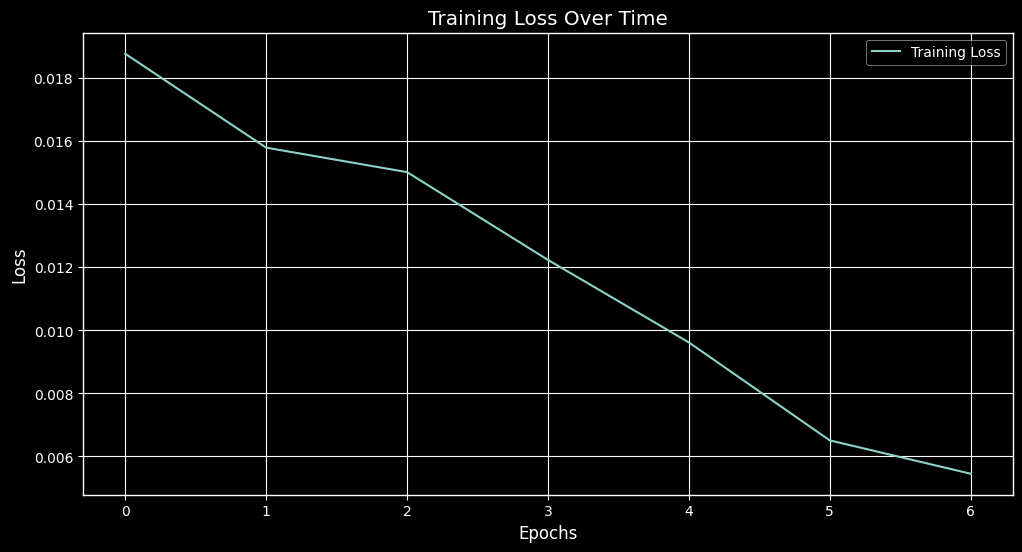

Model saved to models/rhinosurgical_model.pkl


In [21]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            outputs = self(x)
            predicted = (outputs > 0.5).float()
        return predicted

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

num_epochs = 20
batch_size = 32
losses = []

kf = KFold(n_splits=7, shuffle=True, random_state=42)
for fold, (train_ids, val_ids) in enumerate(kf.split(X, y)):
    X_train, X_val = X[train_ids], X[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32).to(device)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i + batch_size]
            labels = y_train_tensor[i:i + batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Fold {fold+1}/{7}, Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(X_train_tensor)}')
    
    losses.append(running_loss / len(X_train_tensor))

    predictions = model.predict(X_val_tensor)
    accuracy = accuracy_score(y_val, predictions.cpu())
    auc = roc_auc_score(y_val, predictions.cpu())
    f1 = f1_score(y_val, predictions.cpu())
    print(f'Fold {fold+1}/{7} Test Accuracy: {accuracy}')
    print(f'Fold {fold+1}/{7} Test F1: {f1}')
    print(f'Fold {fold+1}/{7} Test roc auc: {auc}')

plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'rhinosurgical_model.pkl')
torch.save(model, model_path)
print(f'Model saved to {model_path}')


In [ ]:
print(X_val_tensor[:5])
print(model.predict(X_val_tensor)[:5])
print(y_val[:5])

In [2]:
# Сохранение модели
model_path = 'models/rhinosurgical_model_with_predict_method.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

NameError: name 'torch' is not defined

In [21]:
import pickle

model_dict = {
    'state_dict': model.state_dict(),
    'architecture': {
        'fc1': model.fc1,
        'fc2': model.fc2,
        'dropout2': model.dropout2,
        'fc3': model.fc3,
        'sigmoid': model.sigmoid,
    }
}

with open('rhinosurgical_model.pkl', 'wb') as file:
    pickle.dump(model_dict, file)

with open('rhinosurgical_model.pkl', 'rb') as file:
    loaded_model_dict = pickle.load(file)

loaded_model = SimpleNet()

loaded_model.load_state_dict(loaded_model_dict['state_dict'])


<All keys matched successfully>

In [16]:
print(f'X:{X} \n y:{y}')

X:[[ 2.57257336e-02 -1.45960090e+00 -6.43698264e-01  1.53402178e-01
  -6.58438406e-01  2.81637363e-01 -2.13897101e-01 -7.37572280e-01
   8.01999849e-01  2.78764811e-01]
 [ 2.57257336e-02 -1.45960090e+00  2.91393625e+00  2.61638906e-01
   1.94919942e+00 -1.52264090e+00  3.45548642e-01 -1.91047112e-01
   1.14890251e+00 -4.76166458e-01]
 [-1.36346388e+00 -1.45960090e+00 -5.79014000e-01 -5.14057646e-01
  -1.52875970e-01  5.93916292e-01  1.35888433e+00  7.84470931e-01
   7.61187771e-01 -1.23704207e+00]
 [ 2.57257336e-02 -1.45960090e+00 -1.90908417e-01 -4.96018192e-01
   6.71989056e-01  3.87537509e-02 -8.47231905e-01 -4.26111701e-01
  -9.52919513e-01  9.86141354e-01]
 [-9.00400676e-01 -1.45960090e+00 -7.83847502e-01  4.51654496e-02
  -9.95480029e-01  6.05482179e-01  9.26105545e-01  5.84666030e-01
   7.91796829e-01 -1.05276751e+00]
 [-9.00400676e-01 -1.45960090e+00 -2.44811971e-01  1.71441632e-01
   1.13209522e-01 -2.38827520e-01 -3.51119642e-01  9.31386298e-01
  -6.67234966e-01 -5.53442887e-

In [17]:
!pip install metatreelib
!pip install imodels

In [19]:
from metatree.model_metatree import LlamaForMetaTree as MetaTree
from metatree.decision_tree_class import DecisionTree, DecisionTreeForest
from metatree.run_train import preprocess_dimension_patch
from transformers import AutoConfig
import imodels

# Initialize Model
model_name_or_path = "yzhuang/MetaTree"    

config = AutoConfig.from_pretrained(model_name_or_path)
model = MetaTree.from_pretrained(
    model_name_or_path,
    config=config,
)
decision_tree_forest = DecisionTreeForest()

# Load Datasets
X, y, feature_names = imodels.get_clean_dataset('fico', data_source='imodels')

print("Dataset Shapes X={}, y={}, Num of Classes={}".format(X.shape, y.shape, len(set(y))))

train_idx, test_idx = sklearn.model_selection.train_test_split(range(X.shape[0]), test_size=0.3, random_state=seed)

# Dimension Subsampling
feature_idx = np.random.choice(X.shape[1], 10, replace=False)
X = X[:, feature_idx]

test_X, test_y = X[test_idx], y[test_idx]

# Sample Train and Test Data
subset_idx = random.sample(train_idx, 256)
train_X, train_y = X[subset_idx], y[subset_idx]

input_x = torch.tensor(train_X, dtype=torch.float32)
input_y = torch.nn.functional.one_hot(torch.tensor(train_y)).float()

batch = {"input_x": input_x, "input_y": input_y, "input_y_clean": input_y}
batch = preprocess_dimension_patch(batch, n_feature=10, n_class=10)
model.depth = 2
outputs = model.generate_decision_tree(batch['input_x'], batch['input_y'], depth=model.depth)
decision_tree_forest.add_tree(DecisionTree(auto_dims=outputs.metatree_dimensions, auto_thresholds=outputs.tentative_splits, input_x=batch['input_x'], input_y=batch['input_y'], depth=model.depth))

print("Decision Tree Features: ", [x.argmax(dim=-1) for x in outputs.metatree_dimensions])
print("Decision Tree Threasholds: ", outputs.tentative_splits)


ImportError: cannot import name 'indices_to_mask' from 'sklearn.utils._mask' (/opt/conda/lib/python3.10/site-packages/sklearn/utils/_mask.py)